<a href="https://colab.research.google.com/github/KoreTane/MKTBank/blob/main/MKTBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=7f7a3d2a8c6d64aee8ce10907ccf287d8157aeceb3e714264ee96004ed7ded47
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


# Exploratory Analysis


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("BankMarketing").getOrCreate()
df = spark.read.csv("bank.csv", header=True, inferSchema=True)
# Criar um ID único para cada cliente
df = df.withColumn("client_id", monotonically_increasing_id())

colunas = ['client_id'] + [col for col in df.columns if col != 'client_id']
df = df.select(colunas)

df.show(50)

df.printSchema()

df.summary().show()

+---------+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|      admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|      admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|  technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|    services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| un

In [3]:
# Criar um ID único para cada cliente
df = df.withColumn("client_id", monotonically_increasing_id())

df.show(5)


+---------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
|     

In [4]:
total_count = df.count()

distinct_count = df.distinct().count()

# Verificar se há duplicatas
if total_count > distinct_count:
    print("Existem dados duplicados no DataFrame.")
else:
    print("Não existem dados duplicados no DataFrame.")

Não existem dados duplicados no DataFrame.


In [8]:
# Análises Simples
# 1. age: Contar quantas IDs têm mais de 80 anos
age_above_80 = df.filter(df.age > 80).count()

# 2. Contando IDs agrupados por job e calculando a média do balance
job_count = df.groupBy("job") \
               .agg(
                   F.count("*").alias("count"),  # Contagem de IDs
                   F.format_number(F.avg("balance"), 2).alias("average_balance")  # Média do balance formatada
               ) \
               .sort(F.col("count").desc())

# 3. marital: Contar IDs agrupados por estado civil
marital_count = df.groupBy("marital").count().sort(col("count").desc())

# 4. Contando IDs agrupados por nível de escolaridade e calculando a média do balance
education_count = df.groupBy("education") \
                     .agg(
                         F.count("*").alias("count"),  # Contagem de IDs
                         F.format_number(F.avg("balance"), 2).alias("average_balance")  # Média do balance formatada
                     ) \
                     .sort(F.col("count").desc())

# 5. default: Contar IDs com e sem crédito em atraso
default_count = df.groupBy("default").count()

# 6. balance: Contar quantas IDs estão com balance negativo e positivo
balance_count = df.groupBy(F.when(df.balance < 0, "Negativo").otherwise("Positivo").alias("Balance")).count()

# 7. housing: Contar quantos IDs possuem housing e quantos não
housing_count = df.groupBy("housing").count()

# 8. loan: Contar quantos IDs possuem loan e quantos não
loan_count = df.groupBy("loan").count()

# 9. contact: Contagem do número de IDs agrupada por contact
contact_count = df.groupBy("contact").count()

# 10. day: Contar a distribuição de contatos por dia do mês
day_count = df.groupBy("day").count().sort(col("count").desc())

# 11. month: Contar a distribuição de contatos por mês
month_count = df.groupBy("month").count().sort(col("count").desc())

# 12. duration: Contar quantas IDs têm duração de contato acima e abaixo da média
average_duration = df.select(F.avg("duration")).first()[0]
duration_count = df.groupBy(F.when(df.duration < average_duration, "Abaixo da Média").otherwise("Acima da Média").alias("Duração")).count()

# 13. campaign: Distribuição de contatos feitos durante a campanha
campaign_count = df.groupBy("campaign").count()

# 14. pdays: Distribuição do número de dias desde o último contato (999 significa que nunca foi contatado)
pdays_count = df.groupBy(F.when(df.pdays == 999, "Nunca contatado").otherwise(df.pdays)).count()

# 15. previous: Distribuição do número de contatos anteriores
previous_count = df.groupBy("previous").count()

# 16. poutcome: Contar resultados da campanha anterior
poutcome_count = df.groupBy("poutcome").count()

# 17. deposit: Contagem de aceitação da oferta (sim/não)
deposit_count = df.groupBy("deposit").count()

# Exibindo os resultados em uma matriz

print("Análise Completa de Clientes:")

print(f"\n1. IDs com mais de 80 anos: {age_above_80}")

print("\n2. Contagem de IDs agrupados por Job:")
job_count.show()

print("\n3. Contagem de IDs agrupados por Estado Civil:")
marital_count.show()

print("\n4. Contagem de IDs agrupados por Nível de Escolaridade:")
education_count.show()

print("\n5. Contagem de IDs com e sem Crédito em Atraso:")
default_count.show()

print("\n6. Contagem de IDs com Balance Negativo e Positivo:")
balance_count.show()

print("\n7. Contagem de IDs com Housing:")
housing_count.show()

print("\n8. Contagem de IDs com Loan:")
loan_count.show()

print("\n9. Contagem de IDs agrupados por Contact:")
contact_count.show()

print("\n10. Distribuição de contatos por Dia do Mês:")
day_count.show()

print("\n11. Distribuição de contatos por Mês:")
month_count.show()

print("\n12. A média é: 371 segundos. Duração do contato (Abaixo/Acima da Média):")
duration_count.show()

print("\n13. Distribuição de contatos feitos durante a Campanha:")
campaign_count.show()

print("\n14. Distribuição do Número de Dias desde o Último Contato:")
pdays_count.show()

print("\n15. Distribuição do Número de Contatos Anteriores:")
previous_count.show()

print("\n16. Resultados da Campanha Anterior:")
poutcome_count.show()

print("\n17. Aceitação da Oferta (Sim/Não):")
deposit_count.show()

Análise Completa de Clientes:

1. IDs com mais de 80 anos: 46

2. Contagem de IDs agrupados por Job:
+-------------+-----+---------------+
|          job|count|average_balance|
+-------------+-----+---------------+
|   management| 2482|       1,785.90|
|  blue-collar| 1858|       1,201.72|
|   technician| 1771|       1,516.30|
|       admin.| 1294|       1,191.35|
|     services|  882|       1,034.69|
|      retired|  731|       2,464.50|
|self-employed|  394|       1,871.65|
|   unemployed|  350|       1,326.88|
| entrepreneur|  314|       1,652.57|
|      student|  293|       1,538.98|
|    housemaid|  265|       1,372.28|
+-------------+-----+---------------+


3. Contagem de IDs agrupados por Estado Civil:
+--------+-----+
| marital|count|
+--------+-----+
| married| 6041|
|  single| 3351|
|divorced| 1242|
+--------+-----+


4. Contagem de IDs agrupados por Nível de Escolaridade:
+---------+-----+---------------+
|education|count|average_balance|
+---------+-----+---------------+
|

In [7]:
## Filtrar os registros onde job é igual a "unknown"
unknown_job_df = df.filter(df.education == "unknown")

# Excluir as linhas onde job e education é igual a "unknown"
df = df.filter((df.job != "unknown") & (df.education != "unknown"))

# Substituir "unknown" por "não informado" nas colunas contact e poutcome
df = df.withColumn("contact", F.when(df.contact == "unknown", "não informado").otherwise(df.contact)) \
       .withColumn("poutcome", F.when(df.poutcome == "unknown", "não informado").otherwise(df.poutcome))

# Exibir o DataFrame resultante
df.show()


+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|client_id|age|        job| marital|education|default|balance|housing|loan|      contact|day|month|duration|campaign|pdays|previous|     poutcome|deposit|
+---------+---+-----------+--------+---------+-------+-------+-------+----+-------------+---+-----+--------+--------+-----+--------+-------------+-------+
|        0| 59|     admin.| married|secondary|     no|   2343|    yes|  no|não informado|  5|  may|    1042|       1|   -1|       0|não informado|    yes|
|        1| 56|     admin.| married|secondary|     no|     45|     no|  no|não informado|  5|  may|    1467|       1|   -1|       0|não informado|    yes|
|        2| 41| technician| married|secondary|     no|   1270|    yes|  no|não informado|  5|  may|    1389|       1|   -1|       0|não informado|    yes|
|        3| 55|   services| married|secondary|     no|   2476|    yes|

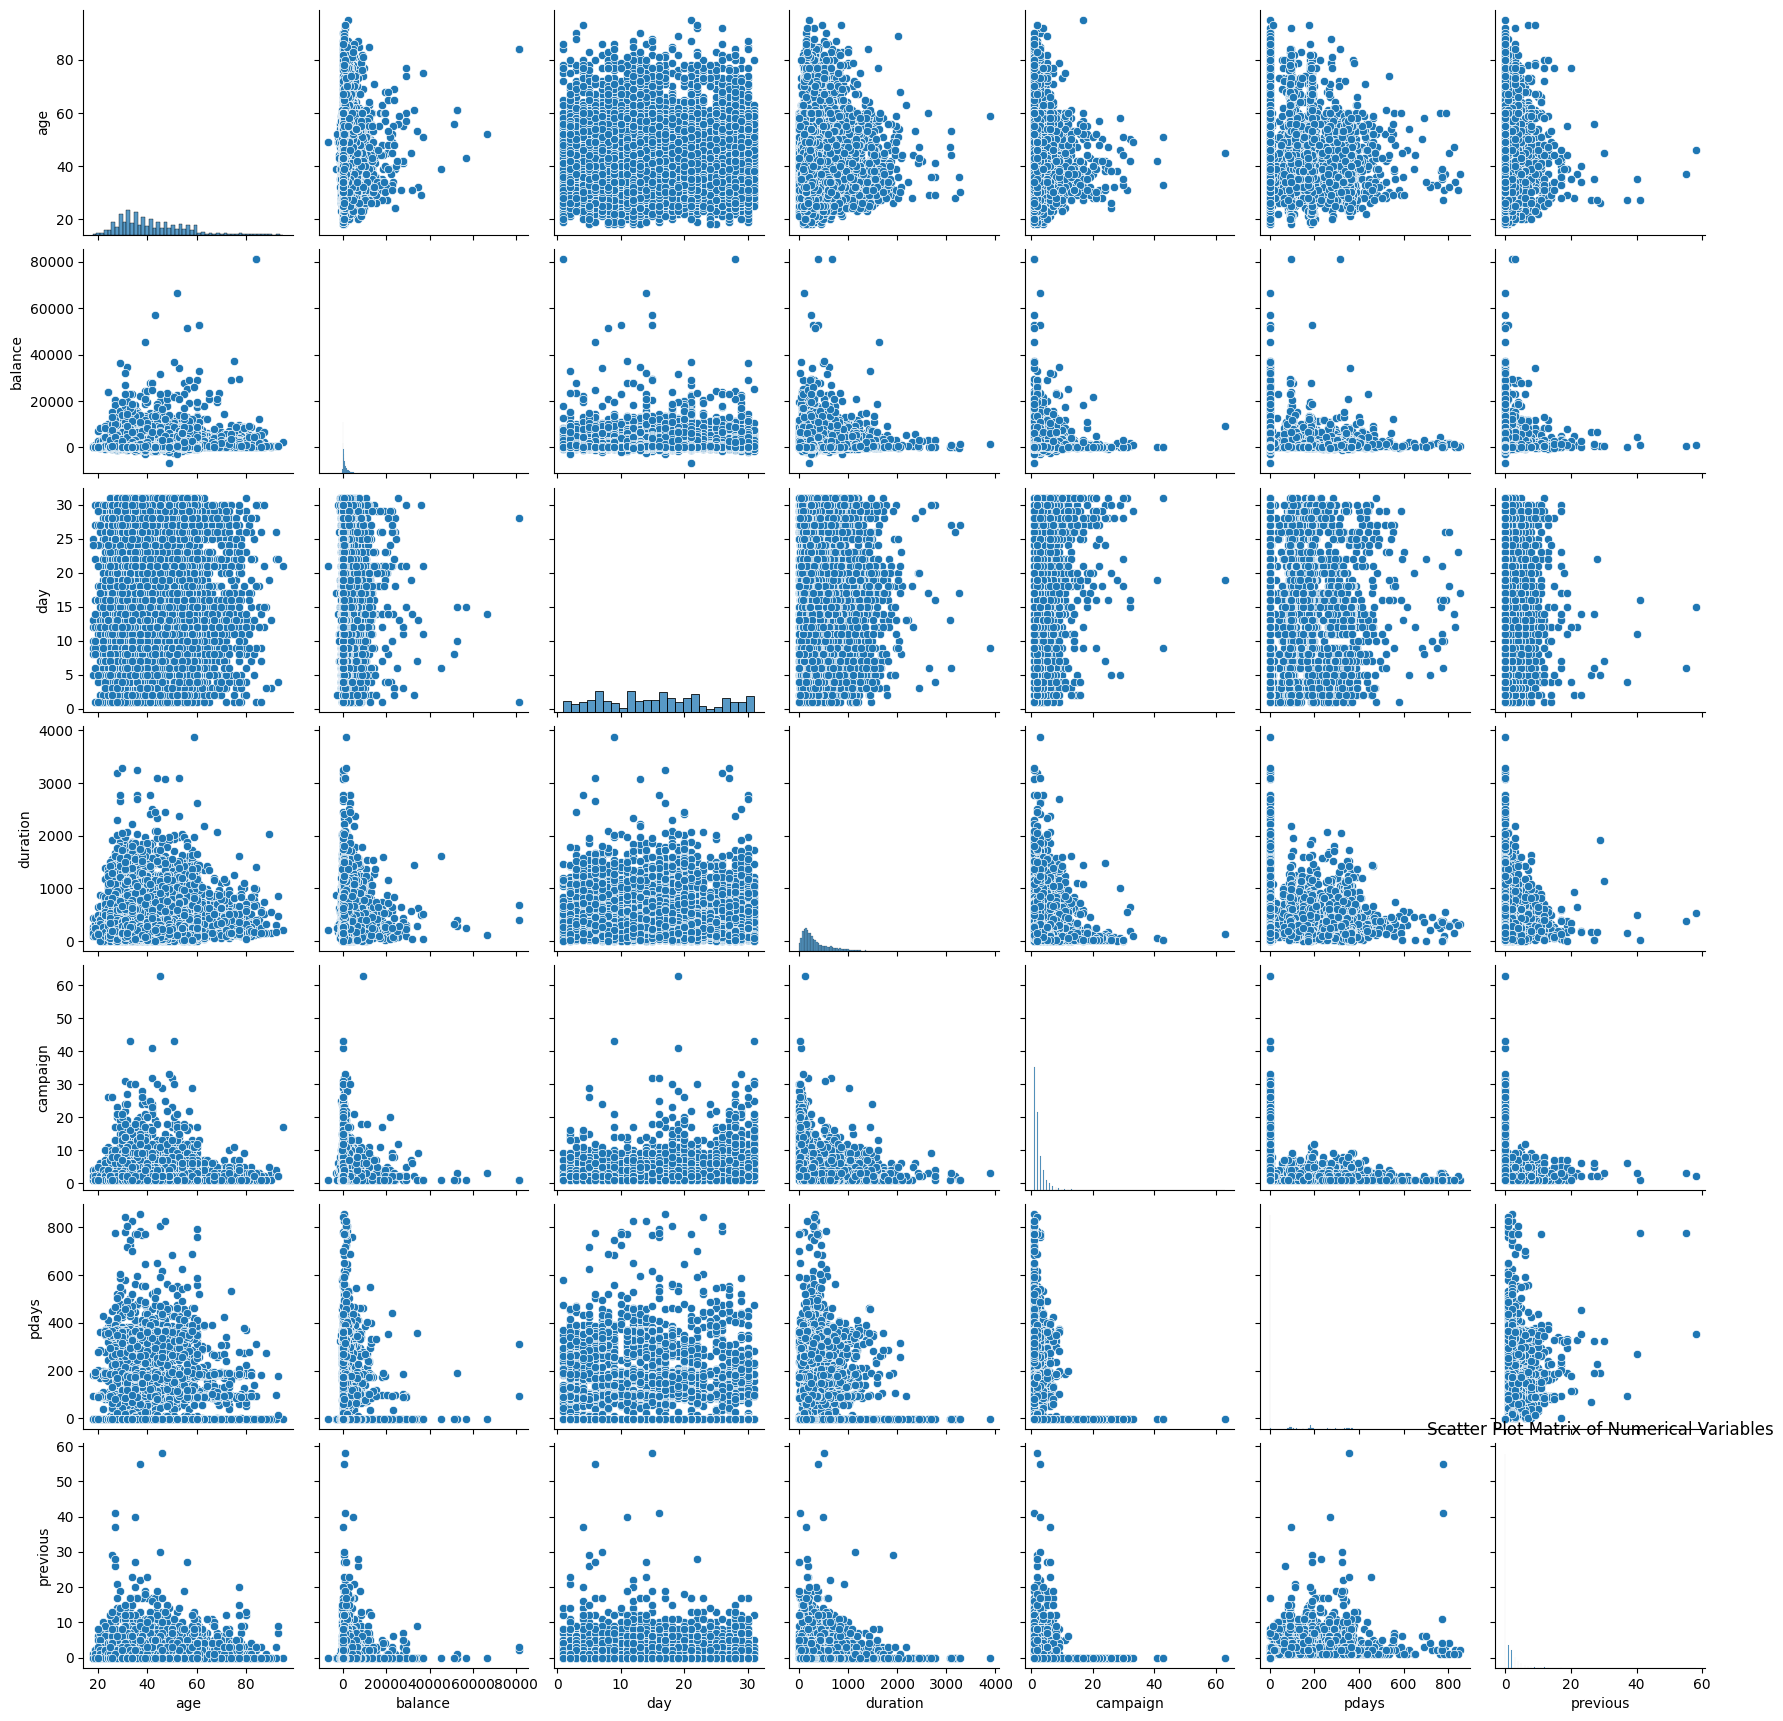

In [15]:
from pyspark.sql.types import IntegerType, DoubleType
import pandas as pd

# Filtrando variáveis numéricas para o scatter plot
numeric_vars = [
    field.name
    for field in df.schema.fields
    if isinstance(field.dataType, (IntegerType, DoubleType))
]
# Convertendo o PySpark DataFrame para pandas DataFrame e selecionando as colunas numéricas
pandas_df = df.select(numeric_vars).toPandas()

# Iniciando a visualização com o pandas DataFrame
sns.pairplot(pandas_df)
plt.title('Scatter Plot Matrix of Numerical Variables')
plt.show()